In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string

# Loading the dataset
def read_dataframe(url) -> pd.DataFrame:
    liar_dataset_url = f"https://raw.githubusercontent.com/thiagorainmaker77/liar_dataset/master/{url}"
    data = pd.read_csv(liar_dataset_url, sep='\t', header=None)
    data.fillna("", inplace=True)
    data.columns = [
        'id',                # Column 1: the ID of the statement ([ID].json).
        'label',            
        'statement',         
        'subjects',          
        'speaker',           
        'speaker_job_title', 
        'state_info',        
        'party_affiliation', 
        'barelyTrueCount', 
        'falseCount', 
        'halfTrueCount', 
        'mostlyTrueCount',
        'pantsOnFireCount', 
        'context' # the context (venue / location of the speech or statement).
    ]
    label_mapping = {
    'true': 5,
    'mostly-true': 4,
    'half-true': 3,
    'barely-true': 2,
    'false': 1,
    'pants-fire': 0
    }

    data['label'] = data['label'].apply(lambda x: label_mapping.get(x, 0))
    #data['statement'] = data['statement'].apply(clean_text)
    return data

train_data= read_dataframe("train.tsv")
test_data = read_dataframe("test.tsv")
valid_data = read_dataframe("valid.tsv")

data = pd.concat([train_data, test_data, valid_data], axis=0)

# Tokenization, stemming, removing stopwords, lowercasing, and removing punctuations
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens if word.isalnum()]
    tokens = [word.lower() for word in tokens]
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['statement'] = data['statement'].apply(preprocess_text)

print(data['statement']);

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Marc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0          say anni list polit group support abort demand
1       declin coal start start natur ga took start be...
2       hillari clinton agre john mccain vote give geo...
3       health care reform legisl like mandat free sex...
4                        econom turnaround start end term
                              ...                        
1279    first time decad import account less half oil ...
1280    say donald trump ha bankrupt hi compani onc tw...
1281    john mccain georg bush absolut plan univers he...
1282    new poll show 62 percent support presid plan r...
1283    one claim report vindic new jersey gov chri ch...
Name: statement, Length: 12791, dtype: object


In [210]:
# encode the data 
dataFrame = data.drop(columns=['id'])
dataFrame= dataFrame.dropna()
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

labelEnc = LabelEncoder()
dataFrame["label"] = labelEnc.fit_transform(dataFrame["label"])
dataFrame.head()


,label,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,barelyTrueCount,falseCount,halfTrueCount,mostlyTrueCount,pantsOnFireCount,context
0,1,say anni list polit group support abort demand,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,3,declin coal start start natur ga took start be...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,4,hillari clinton agre john mccain vote give geo...,foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1,health care reform legisl like mandat free sex...,health-care,blog-posting,,,none,7.0,19.0,3.0,5.0,44.0,a news release
4,3,econom turnaround start end term,"economy,jobs",charlie-crist,,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


<Axes: xlabel='label', ylabel='count'>

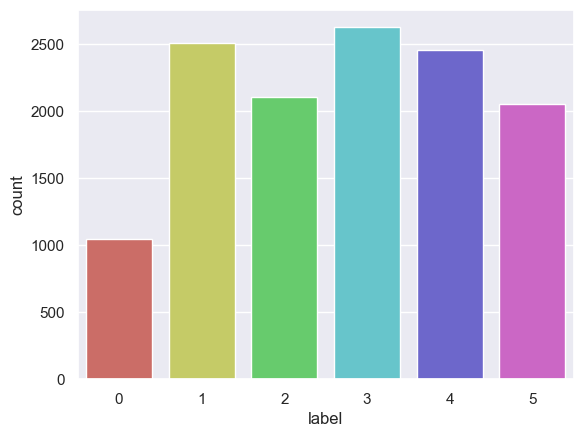

In [211]:
dataFrame['label'] = dataFrame['label'].astype('int')
sns.countplot(x='label', data=dataFrame, palette='hls')

In [212]:
df= dataFrame.drop(columns=['subjects', 'speaker_job_title', 'state_info', 'party_affiliation', 'barelyTrueCount', 'falseCount', 'halfTrueCount', 'mostlyTrueCount','pantsOnFireCount'])
df.head()

,label,statement,speaker,context
0,1,say anni list polit group support abort demand,dwayne-bohac,a mailer
1,3,declin coal start start natur ga took start be...,scott-surovell,a floor speech.
2,4,hillari clinton agre john mccain vote give geo...,barack-obama,Denver
3,1,health care reform legisl like mandat free sex...,blog-posting,a news release
4,3,econom turnaround start end term,charlie-crist,an interview on CNN


In [213]:
dataFrame= dataFrame.drop(columns=['subjects', 'speaker_job_title', 'state_info', 'party_affiliation', 'barelyTrueCount', 'falseCount', 'halfTrueCount', 'mostlyTrueCount','pantsOnFireCount'])
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12791 entries, 0 to 1283
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      12791 non-null  int32 
 1   statement  12791 non-null  object
 2   speaker    12791 non-null  object
 3   context    12791 non-null  object
dtypes: int32(1), object(3)
memory usage: 449.7+ KB


In [214]:
X = dataFrame.iloc[:,1].values #stores text
Y= dataFrame.iloc[:,0].values #stores label
print(X)
print(Y)

['say anni list polit group support abort demand'
 'declin coal start start natur ga took start begin presid georg bush administr'
 'hillari clinton agre john mccain vote give georg bush benefit doubt iran'
 ... 'john mccain georg bush absolut plan univers health care'
 'new poll show 62 percent support presid plan reform health care mean let choos keep privat insur public health insur plan'
 'one claim report vindic new jersey gov chri christi bridg scandal conclus']
[1 3 4 ... 5 1 2]


In [215]:
print(type(X))
print(type(Y))
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.25, random_state = 0)

# use TFIDVectorizer to make the text into numerical values
vectorizer= TfidfVectorizer()
tfid_fit = vectorizer.fit(X_train)
X_train_tf = tfid_fit.transform(X_train)
X_test_tf = tfid_fit.transform(X_test)

X_train_tf.toarray().shape

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


(9593, 7735)

In [216]:
def logRegModel(X_train, y_train):
    log = LogisticRegression(random_state=0)
    X_train_tf_array = X_train_tf.toarray()
    log.fit(X_train_tf_array, y_train)
    print('Logistic Regression Accuracy of train data: ', log.score(X_train_tf_array, y_train))
    return log

from sklearn.tree import DecisionTreeClassifier

def decistreeModel(X_train_tf, y_train):
    dtree = DecisionTreeClassifier(random_state=0)
    dtree.fit(X_train_tf, y_train)
    print('Decision Tree Accuracy on train data: ', dtree.score(X_train_tf, y_train))
    return dtree

lrModel = logRegModel(X_train, y_train)

print(lrModel)

Logistic Regression Accuracy of train data:  0.6143020952778068
LogisticRegression(random_state=0)


C:\Users\Seeleena Mohammed\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [217]:
dtree = decistreeModel(X_train_tf, y_train)

print(dtree)

Decision Tree Accuracy on train data:  0.9995830292921922
DecisionTreeClassifier(random_state=0)


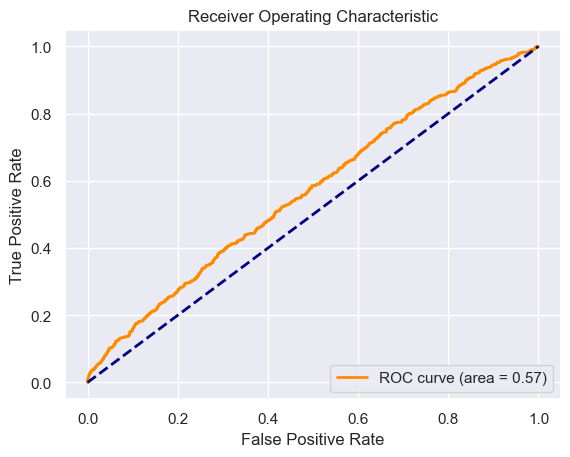

In [218]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Convert multilabel-indicator format to binary format
y_test_binary = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])

def evaluate_model(model, X_test, y_test):
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test)
        
        # For binary classification, select a specific class (e.g., class 1)
        y_test_binary = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])[:, 1]
        
        fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_prob[:, 1])
        roc_auc = roc_auc_score(y_test_binary, y_pred_prob[:, 1])
        
        # Plot the ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

# Call the evaluation function with the adjusted binary labels
evaluate_model(tuned_lr_model, X_test_tf, y_test)

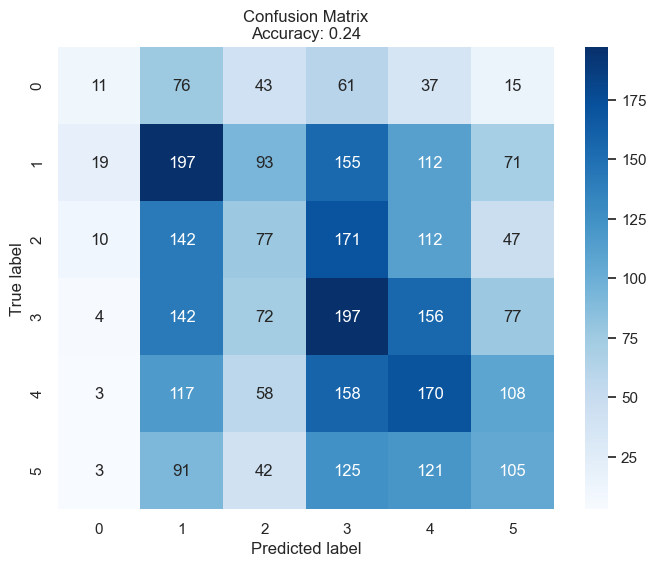

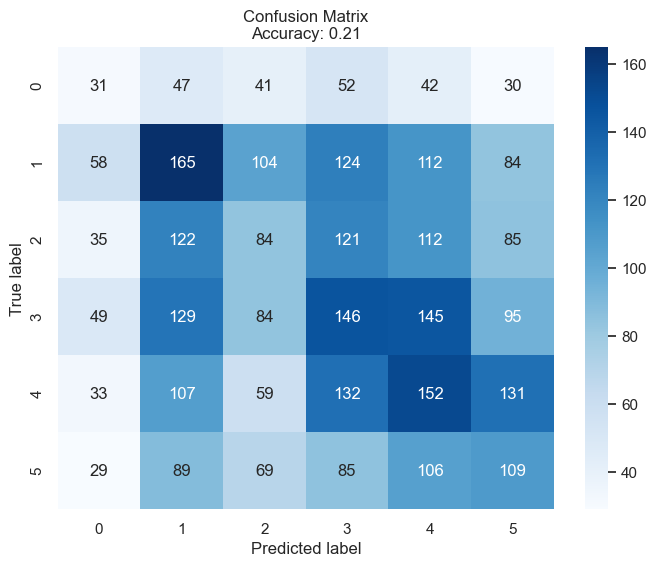

In [219]:
def plot_confusion_matrix(model, X_test, y_test):
    from sklearn.metrics import confusion_matrix, accuracy_score
    import matplotlib.pyplot as plt
    import seaborn as sns

    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}')
    plt.show()

plot_confusion_matrix(lrModel, X_test_tf, y_test)
plot_confusion_matrix(dtree, X_test_tf, y_test)

In [220]:
prediction= lrModel.predict(X_test_tf)
print("Model prediction value: ", prediction)

print()
print("Actual values: ", y_test)

Model prediction value:  [1 3 1 ... 3 3 5]

Actual values:  [2 1 1 ... 3 3 4]


In [221]:
prediction= dtree.predict(X_test_tf)
print("Model prediction value: ", prediction)

print()
print("Actual values: ", y_test)

Model prediction value:  [3 1 0 ... 0 2 5]

Actual values:  [2 1 1 ... 3 3 4]


In [226]:
import pandas as pd

def process_news(news):
    inputData = {"statement": news}
    input = pd.DataFrame(inputData, index=[0])
    input["statement"]=input["statement"].apply(preprocess_text)
    statement = input["statement"]
    
    vectorize_data = vectorizer.transform(statement)
    prediction= lrModel.predict(vectorize_data)
    print(prediction)
    
    if prediction == 0:
        print("Barely True")
    elif prediction == 1:
        print ("False")
    elif prediction == 2:
        print ("Half True")
    elif prediction == 3:
        print ("Mostly True")
    elif prediction == 4:
        print ("Pants on fire")
    else:
        print ("True")

process_news("Polifact Texas says Congressman Edwards attacks on Bill Flores are false")

[2]
Half True
